In [9]:
adj_list_location = "../data/adjacency_list.csv"
geojson_location = "../data/vaprecincts2013.geojson"

In [225]:
import pandas as pd
import geopandas as gpd
import igraph
from rtree import index
import random

In [226]:
geo_df = gpd.read_file(geojson_location).to_crs({'init' : 'epsg:3687'})

In [8]:
geo_df[geo_df["PRECINCT"] == '001']

,PRECINCT,COUNTY,PRECINCT2,CODE,NAME,geometry
17,001,770,0001,7700001,HIGHLAND 1,"POLYGON ((3369484.720854738 1105958.277720217,..."
24,001,810,0001,8100001,NORTH BEACH,"POLYGON ((3724404.044834437 1063363.491314226,..."
141,001,530,0001,5300001,FIRST WARD,"POLYGON ((3425970.940243367 1155519.467685004,..."
255,001,520,0001,5200001,FIRST WARD,"POLYGON ((3165115.154699003 1035751.262412749,..."
380,001,685,0001,6850001,PRECINCT ONE,"POLYGON ((3593412.151182791 1271014.078470423,..."
439,001,610,0001,6100001,FIRST WARD,"POLYGON ((3614931.371911073 1283447.895843895,..."
681,001,640,0001,6400001,EAST,"POLYGON ((3286244.016052797 1042950.00822324, ..."
690,001,590,0001,5900001,WARD ONE,"POLYGON ((3421296.685954724 1028176.391220204,..."
841,001,720,0001,7200001,EAST WARD,"POLYGON ((3129421.076528723 1073139.086425547,..."
891,001,775,0001,7750001,NORTH SALEM NO 2,"POLYGON ((3362164.389100533 1107676.581165892,..."


In [227]:
idx = index.Index()

In [228]:
geo_buffer = geo_df.assign(geometry = geo_df.buffer(50))

In [99]:
geo_buffer.plot()

In [229]:
for i, poly in geo_buffer.iterrows():
    idx.insert(i, poly.geometry.bounds)

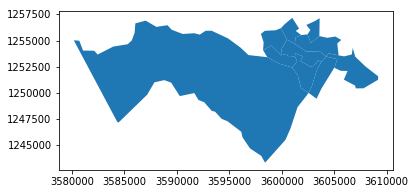

In [230]:
geo_buffer_list = [x[1] for x in list(geo_buffer.iterrows())]
precinct = geo_buffer_list[10]
geo_df.iloc[list(idx.intersection(precinct.geometry.bounds))].plot()

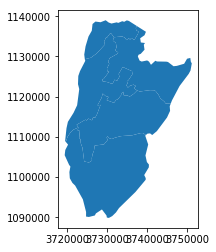

In [231]:
precinct = [x for x in geo_buffer_list if x.CODE == '1310401'][0]
geo_df.iloc[list(idx.intersection(precinct.geometry.bounds))].plot()


In [232]:
edges = []
for i, precinct in geo_df.iterrows():
    precinct_id = precinct.CODE
    matching_precincts = list(idx.intersection(precinct.geometry.bounds))
    matching_precinct_ids = list(geo_df.iloc[matching_precincts].CODE)
    new_edges = [(precinct_id, matched_id) for matched_id in matching_precinct_ids]
    edges += new_edges

In [140]:
len(edges)

22408

In [234]:
pd.DataFrame(edges, columns=["source_id", "target_id"]).to_csv(adj_list_location, index=False)

In [235]:
adj_df = pd.read_csv(adj_list_location, dtype=str)
adj_list =  [list(row[1]) for row in adj_df.iterrows()]
distinct_precincts = list(geo_df["CODE"].unique())
graph = igraph.Graph()
graph.add_vertices(distinct_precincts)
graph.add_edges(adj_list)

In [144]:
len(graph.vs)

2417

In [145]:
len(graph.es)

22408

In [147]:
len(geo_df)

2417

In [148]:
len(graph.components())

3

In [153]:
node = graph.vs[0]


[0, 1141, 1810, 1834, 1837, 1838, 1840, 1841]

In [191]:
def get_subgraph_nbhd(subgraph, graph):
    subgraph_indices = [vertex['name'] for vertex in subgraph.vs]
    nbhd_indices = [graph.vs[x]['name'] for y in graph.neighborhood(subgraph_indices) for x in y if graph.vs[x]['name'] not in subgraph_indices]
    return nbhd_indices

In [195]:
subgraph = graph.subgraph([0, 100])
new_indices = get_subgraph_nbhd(subgraph, graph)

In [196]:
added_vertex = random.choice(new_indices)

In [197]:
new_subgraph = graph.subgraph(subgraph.vs['name'] + [added_vertex])

In [198]:
list(new_subgraph.vs)

[igraph.Vertex(<igraph.Graph object at 0x131870318>, 0, {'name': '0410110'}),
 igraph.Vertex(<igraph.Graph object at 0x131870318>, 1, {'name': '0730501'}),
 igraph.Vertex(<igraph.Graph object at 0x131870318>, 2, {'name': '0410109'})]

In [281]:
def add_random_neighbor(subgraph, graph, used_vertices):
    new_indices = [index for index in get_subgraph_nbhd(subgraph, graph) if index not in used_vertices]
    if len(new_indices) > 0:
        added_vertex = random.choice(new_indices)
        subgraph = graph.subgraph(subgraph.vs['name'] + [added_vertex])
        return added_vertex, subgraph
    else: 
        return None, subgraph


In [241]:
subgraph = graph.subgraph([1000])
for i in range(500):
    _, subgraph = add_random_neighbor(subgraph, graph)

In [225]:
names = list(subgraph.vs['name'])

In [231]:
geo_df[list(map(lambda x: x in names, geo_df.CODE))].plot()

In [318]:
seed_vertices = random.choices(list(graph.vs['name']), k=11)

In [319]:
district_ids = range(len(seed_vertices))
used_vertices = seed_vertices
unused_vertices = [name for name in list(graph.vs['name']) if name not in used_vertices]
subgraphs = [graph.subgraph(vertex) for vertex in seed_vertices]

In [320]:
district_ids = range(len(seed_vertices))
while len(unused_vertices) > 22:
    random_subgraph_id = random.choice(district_ids)
    random_subgraph = subgraphs[random_subgraph_id]
    added_vertex, new_subgraph = add_random_neighbor(random_subgraph, graph, used_vertices)
    subgraphs[random_subgraph_id] = new_subgraph
    if added_vertex:
        used_vertices += [added_vertex]
        unused_vertices.remove(added_vertex)

range(0, 30)

In [321]:
for id in district_ids:
    district = subgraphs[id]
    district_ids = list(district.vs['name'])
    geo_df.loc[geo_df['CODE'].isin(district_ids), "district"] = id

In [322]:
geo_df.plot(column = "district")

/Users/msp/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [307]:
geo_df[geo_df["district"].isnull()]

,PRECINCT,COUNTY,PRECINCT2,CODE,NAME,geometry,district
102,101,131,0101,1310101,PRECINCT 1-1,"POLYGON ((3739657.843542578 1110438.621873228,...",NaN
167,803,001,0803,0010803,WACHAPREAGUE,"POLYGON ((3748150.603483862 1149934.277000266,...",NaN
169,801,001,0801,0010801,BOBTOWN,"POLYGON ((3738962.021602001 1152203.912699004,...",NaN
253,301,001,0301,0010301,OAK HALL,"POLYGON ((3764244.384992584 1181589.444002362,...",NaN
294,901,001,0901,0010901,PAINTER,"POLYGON ((3744349.197655383 1146838.079710923,...",NaN
582,101,001,0101,0010101,CHINCOTEAGUE,"POLYGON ((3771899.959674231 1175542.430991367,...",NaN
628,201,131,0201,1310201,PRECINCT 2-1,"POLYGON ((3737476.294791277 1121514.329777443,...",NaN
765,401,131,0401,1310401,PRECINCT 4-1,"POLYGON ((3731721.988890339 1134764.349868226,...",NaN
951,501,131,0501,1310501,PRECINCT 5-1,"POLYGON ((3737317.450421249 1137608.185610337,...",NaN
956,601,001,0601,0010601,ACCOMAC,"POLYGON ((3749969.293498054 1163253.493299586,...",NaN


In [75]:
import scipy as sp
from scipy.sparse import lil_matrix
import numpy as np

In [236]:
num_precincts = len(distinct_precincts)
index_to_precinct = dict(enumerate(distinct_precincts))
precinct_to_index = {v:k for (k,v) in index_to_precinct.items()}

In [237]:
adj_mat_lil = lil_matrix((num_precincts, num_precincts), dtype=np.float32)
entries = [(precinct_to_index[x], precinct_to_index[y]) for x,y in adj_list]
for x,y in entries:
    if x != y:
        adj_mat_lil[x,y] = 1
        adj_mat_lil[y,x] = 1

In [238]:
adj_mat = adj_mat_lil.tocsr()

In [239]:
degrees = np.asarray(np.sum(adj_mat, axis=0)).squeeze()

In [240]:
laplacian_mat_lil = lil_matrix((num_precincts, num_precincts), dtype=np.float32)
for x,y in entries:
    if x != y:
        deg_x = degrees[x]
        deg_y = degrees[y]    
        val = - 1/np.sqrt((deg_x * deg_y))
        laplacian_mat_lil[x,y] = val
        laplacian_mat_lil[y,x] = val
for x in range(num_precincts):
    laplacian_mat_lil[x,x] = 1

In [241]:
laplacian_mat = laplacian_mat_lil.tocsr()

In [242]:
alpha = 0.001
num_districts = 11
import random
random_starts = random.choices(range(num_precincts), k=num_districts)
label_matrix_lil = lil_matrix((num_precincts, num_districts))
for district_num, start in enumerate(random_starts):
    label_matrix_lil[start, district_num] = 1

In [243]:
initial_label_matrix = label_matrix_lil.tocsr()

In [244]:
label_matrix = initial_label_matrix.copy()

In [245]:
for i in range(1000):
    label_matrix = alpha*np.dot(laplacian_mat, label_matrix) + (1-alpha)*initial_label_matrix

In [246]:
districts = np.asarray(np.argmax(label_matrix, axis=1)).squeeze()

In [247]:
for i in range(num_precincts):
    precinct_code = index_to_precinct[i]
    district_id = districts[i]
    geo_df.loc[geo_df['CODE'] == precinct_code, "district"] = district_id

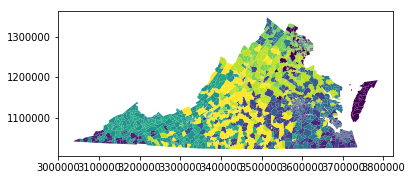

In [248]:
%matplotlib inline
geo_df.plot(column = "district")


In [210]:
geo_df.to_file(driver='GeoJSON', filename="/Users/msp/Desktop/t.geojson")